In [1]:
%matplotlib inline

In [2]:
SUMMARY="No Notifications, 3Mbps Traffic"

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [4]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

In [5]:
def load_dataset(name):
    with open(name) as fp:
        a = np.loadtxt(fp)
    return a

def get_sigma():
    with open("mod_labels.dat") as fp:
        contents = list(fp)
        return float(contents[0].strip())

def get_labels():
    with open("mod_labels.dat") as fp:
        contents = list(fp)
        items = map(lambda x: x.strip().split(), contents[1:])
        return map(lambda (x,y): (int(x),y), items)

In [6]:
siminfo = json.load(open("simulationinfo.json"))
router = int(siminfo["router"])
bridge1 = int(siminfo["n_bridge"])
bridge2 = int(siminfo["m_bridge"])

In [7]:
router_i1 = load_dataset("router_top_queue.dat".format(router))
router_i2 = load_dataset("router_bottom_queue.dat".format(router))
bridge1_i = load_dataset("bridge_top_queue.dat".format(bridge1))
bridge2_i = load_dataset("bridge_bottom_queue.dat".format(bridge2))

In [8]:
np.max(router_i1[:,1])

57.0

In [9]:
np.max(router_i2[:,1])

56.0

In [10]:
np.max(bridge1_i[:,1])

254.0

In [11]:
np.max(bridge2_i[:,1])

216.0

In [12]:
router_i1[:1000]

array([[ 0.99643472,  1.        ,  0.        ],
       [ 0.99643472,  0.        ,  0.        ],
       [ 0.99703688,  1.        ,  0.        ],
       ..., 
       [ 4.99851591,  0.        ,  2.00398233],
       [ 4.99938755,  1.        ,  1.99997436],
       [ 4.99938755,  0.        ,  1.99997436]])

In [13]:
def biggest_in_range(a, x, spread):
    m = []
    for v in a:
        if x-spread <= v[0] <= x+spread:
            m.append(v[1])
    try:
        return max(m)
    except ValueError:
        return 5
bir = biggest_in_range

In [14]:
def ewma_plot(data):
    WQ = 0.0002
    r = []
    ov = 0.0
    for (x,y) in data:
        nv = (1.0-WQ)*ov+WQ*y
        r.append([x,nv])
        ov = nv
    return np.array(r)

In [15]:
def select_time_interval(data, start, stop):
    r = []
    for q in data:
        if start <= q[0] <= stop:
            r.append(q)
        elif q[0] > stop:
            break
    return np.array(r)

In [16]:
def plot_queue(data, start=None, stop=None):
    #ewma = ewma_plot(data)
    if start != None and stop != None:
        data = select_time_interval(data,start,stop)
        #ewma = select_time_interval(ewma,start,stop)
    plt.plot(data[:,0], data[:,1], data[:,0], data[:,2])
    labels = get_labels()
    for x, anno in labels:
        x /= 1000.0
        s = (get_sigma() / 1000.0) * 100
        plt.annotate(anno, xy=(x,bir(data, x, s)))
    return plt

def plot_ewma(data, start=None, stop=None):
    #ewma = ewma_plot(data)
    if start != None and stop != None:
        data = select_time_interval(data,start,stop)
        #ewma = select_time_interval(ewma,start,stop)
    plt.plot(data[:,0], data[:,2])
    labels = get_labels()
    for x, anno in labels:
        x /= 1000.0
        s = (get_sigma() / 1000.0) * 100
        plt.annotate(anno, xy=(x,bir(data, x, s)))
    return plt

In [17]:
def queue_form(xvals, center, sigma, height):
    from scipy.special import erf
    y = np.array(xvals)
    #200*.5[1+erf(x/(0.005*sqrt(2)))]
    y -= center
    y /= (sigma*np.sqrt(2))
    y = erf(y)
    y += 1
    y *= height * .5
    return y

In [18]:
def plot_queue_fancy(data, start=None, stop=None, ewma=True, title=''):
    #ewma = ewma_plot(data)
    if start != None and stop != None:
        data = select_time_interval(data,start,stop)
        #ewma = select_time_interval(ewma,start,stop)
    plt.title("Queue Size Over Time"+(" ({})".format(title) if title else ''))
    plt.xlabel("Time (seconds)")
    plt.ylabel("Queue Size (packets)")
    plt.style.use('grayscale')
    hndls = []
    p1, = plt.plot(data[:,0], data[:,1], label="Queue Size")
    p3, = plt.plot(data[:,0], queue_form(data[:,0], 121.005, 0.005, 197))
    hndls.append(p1)
    if ewma:
        p2, = plt.plot(data[:,0], data[:,2], label="Avg. Queue Size", ls='dotted')
        hndls.append(p2)
    #plt.legend(handles=hndls)
    plt.xlim([start,stop])
    labels = get_labels()
    for x, anno in labels:
        x /= 1000.0
        s = (get_sigma() / 1000.0) * 100
        plt.annotate(anno, xy=(x,bir(data, x, s)))
    timestr = '{}s-{}s'.format(start,stop) if start and stop else 'all'
    detail = title.replace(',','-').replace(' ','').lower()
    filename = 'qsizeot-{}-{}'.format(detail,timestr)
    if not ewma:
        filename += '-noewma'
    plt.savefig(filename+".pdf")
    return plt


In [19]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold='nan',precision=12)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

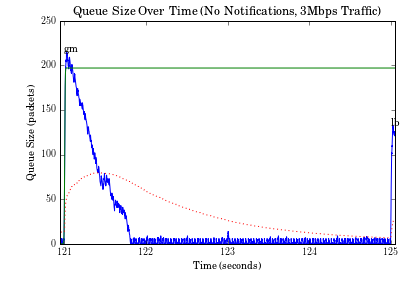

In [20]:
plot_queue_fancy(bridge2_i, start=120.95, stop=125.05, title=SUMMARY)

In [21]:
data = select_time_interval(bridge2_i,119.85,125.05)
print np.max(data)
fullprint(data)

215.0
array([[ 119.850876525   ,    7.            ,   30.62162727855 ],
       [ 119.851305286   ,    6.            ,   30.62162727855 ],
       [ 119.851461123   ,    7.            ,   30.57238402165 ],
       [ 119.851990884   ,    6.            ,   30.57238402165 ],
       [ 119.852984482   ,    5.            ,   30.57238402165 ],
       [ 119.855146721   ,    6.            ,   30.52123925118 ],
       [ 119.855765319   ,    7.            ,   30.47219677035 ],
       [ 119.856508917   ,    8.            ,   30.42525237458 ],
       [ 119.85681908    ,    7.            ,   30.42525237458 ],
       [ 119.858379678   ,    6.            ,   30.42525237458 ],
       [ 119.861718557   ,    5.            ,   30.42525237458 ],
       [ 119.862441436   ,    4.            ,   30.42525237458 ],
       [ 119.863125315   ,    3.            ,   30.42525237458 ],
       [ 119.863930194   ,    2.            ,   30.42525237458 ],
       [ 119.865268073   ,    1.            ,   30.42525237458 ],
    

In [22]:
print np.max(data[:,2])

79.6561632547


<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

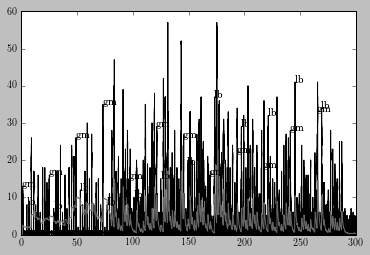

In [23]:
plot_queue(router_i1)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

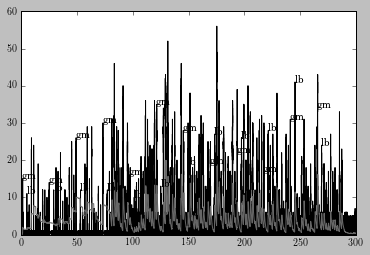

In [24]:
plot_queue(router_i2)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

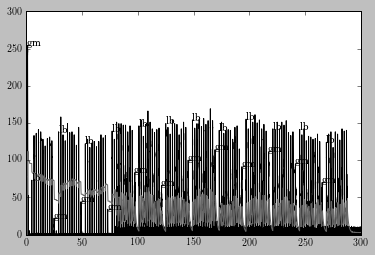

In [25]:
plot_queue(bridge1_i)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

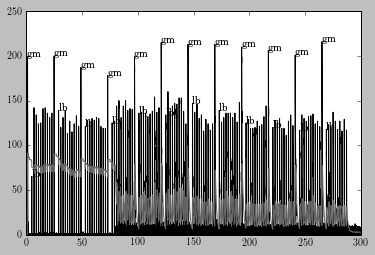

In [26]:
plot_queue(bridge2_i)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

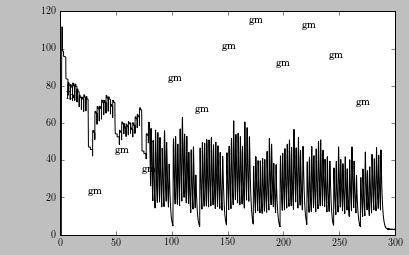

In [27]:
plot_ewma(bridge1_i)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

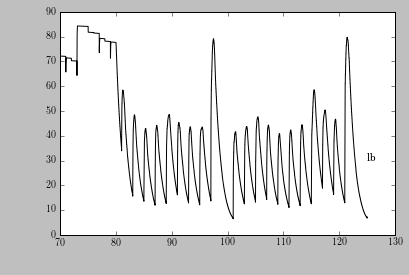

In [28]:
plot_ewma(bridge2_i,70,125)

In [29]:
def plot_many(data):
    x = data[:,0]
    ys = [data[:,i] for i in range(1,len(data[0]))]
    args = []
    for y in ys:
        args.append(x)
        args.append(y)
    plt.plot(*args)
    return plt

In [30]:
def plot_migrations_fancy(data, start=None, stop=None, title=''):
    #ewma = ewma_plot(data)
    if start != None and stop != None:
        data = select_time_interval(data,start,stop)
        #ewma = select_time_interval(ewma,start,stop)
    plt.title("Net Generation over Time"+(" ({})".format(title) if title else ''))
    plt.xlabel("Time (seconds)")
    plt.ylabel("Generation")
    plt.style.use('grayscale')
    hndls = []
    x = data[:,0]
    ys = [data[:,i] for i in range(1,len(data[0]))]
    for i,y in enumerate(ys):
        px, = plt.plot(x, y, label="DGI {} Net Generation".format(i))
        hndls.append(px)
    #plt.legend(handles=hndls)
    timestr = '{}s-{}s'.format(start,stop) if start and stop else 'all'
    detail = title.replace(',','-').replace(' ','').lower()
    filename = 'migrations-{}-{}'.format(detail,timestr)
    plt.savefig(filename+".pdf")
    return plt

In [31]:
def plot_lostm_fancy(data, start=None, stop=None, title=''):
    #ewma = ewma_plot(data)
    if start != None and stop != None:
        data = select_time_interval(data,start,stop)
        #ewma = select_time_interval(ewma,start,stop)
    plt.title("Lost Migrations over Time"+(" ({})".format(title) if title else ''))
    plt.xlabel("Time (seconds)")
    plt.ylabel("Lost Migrations")
    plt.style.use('grayscale')
    hndls = []
    x = data[:,0]
    ys = [data[:,i] for i in range(1,len(data[0]))]
    ym = sum(ys)
    px, = plt.plot(x, ym, label="Lost Migrations".format(i))
    hndls.append(px)
    #plt.legend(handles=hndls)
    timestr = '{}s-{}s'.format(start,stop) if start and stop else 'all'
    detail = title.replace(',','-').replace(' ','').lower()
    filename = 'lostm-{}-{}'.format(detail,timestr)
    plt.savefig(filename+".pdf")
    return plt

In [32]:
def plot_group_fancy(data, start=None, stop=None, title=''):
    #ewma = ewma_plot(data)
    df = []
    for item in data:
        x = item[0]
        y = sum(item[1:])
        if y <= 30:
            df.append(item)
    data = np.array(df)
    if start != None and stop != None:
        data = select_time_interval(data,start,stop)
        #ewma = select_time_interval(ewma,start,stop)
    plt.title("Process Grouping over Time"+(" ({})".format(title) if title else ''))
    plt.xlabel("Time (seconds)")
    plt.ylabel("Groupsize")
    plt.style.use('grayscale')
    hndls = []
    x = data[:,0]
    ys = [data[:,i] for i in range(1,len(data[0]))]
    plt.stackplot(x, *ys)
    #hndls.append(px)
    #plt.legend(handles=hndls)
    timestr = '{}s-{}s'.format(start,stop) if start and stop else 'all'
    detail = title.replace(',','-').replace(' ','').lower()
    filename = 'grouping-{}-{}'.format(detail,timestr)
    plt.savefig(filename+".pdf")
    return plt

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

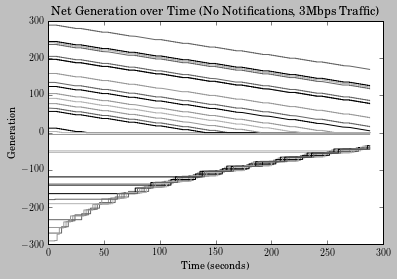

In [33]:
m = load_dataset("migrations.dat")
plot_migrations_fancy(m,title=SUMMARY)

In [34]:
sum(m[-1][1:])

354.0

In [35]:
sum(m[0][1:])

354.0

In [36]:
sum(np.abs(m[-1][1:]-m[0][1:]))/2

1604.0

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

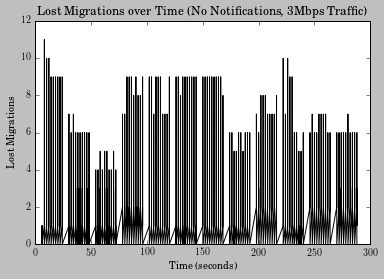

In [37]:
m = load_dataset("losses.dat")
plot_lostm_fancy(m,title=SUMMARY)

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

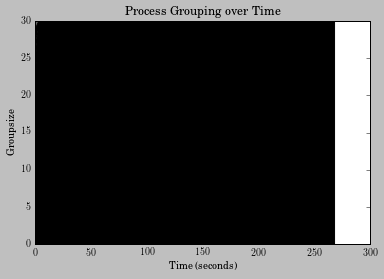

In [38]:
m = load_dataset("groupsizes.dat")
plot_group_fancy(m)